In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib qt
import sys; sys.path.insert(0, '../')
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import mne
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
pp = dict(surface='white', hemi='both')

In [2]:
info = get_info(kind='biosemi128')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]
n_chans, n_dipoles = leadfield.shape

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.4s remaining:    4.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.4s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished


# Simulate

-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


  0%|          | 0/2 [00:00<?, ?it/s]c:\Users\lukas\virtualenvs\invertenv\lib\site-packages\esinet\simulation.py:387: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.simulation_info = self.simulation_info.append(d, ignore_index=True)
c:\Users\lukas\virtualenvs\invertenv\lib\site-packages\esinet\simulation.py:387: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.simulation_info = self.simulation_info.append(d, ignore_index=True)
100%|██████████| 2/2 [00:00<?, ?it/s]


source data shape:  (1284, 10) (1284, 10)


100%|██████████| 2/2 [00:00<00:00, 250.14it/s]


Using pyvistaqt 3d backend.

Using control points [0.         0.         0.35566236]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


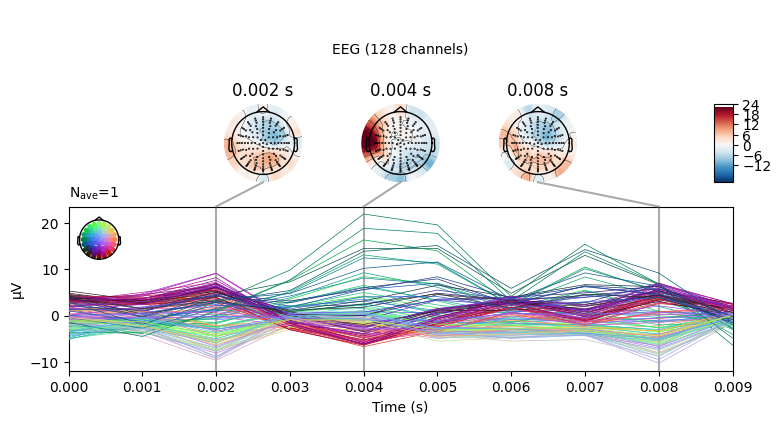

In [3]:
settings = dict(number_of_sources=3, extents=(1, 25), duration_of_trial=0.01, target_snr=5)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()

stc.data /= abs(stc.data).max()
brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)
evoked.plot_joint()

# Solve

Using control points [0.         0.         0.53686736]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
No projector specified for this dataset. Please consider the method self.add_proj.


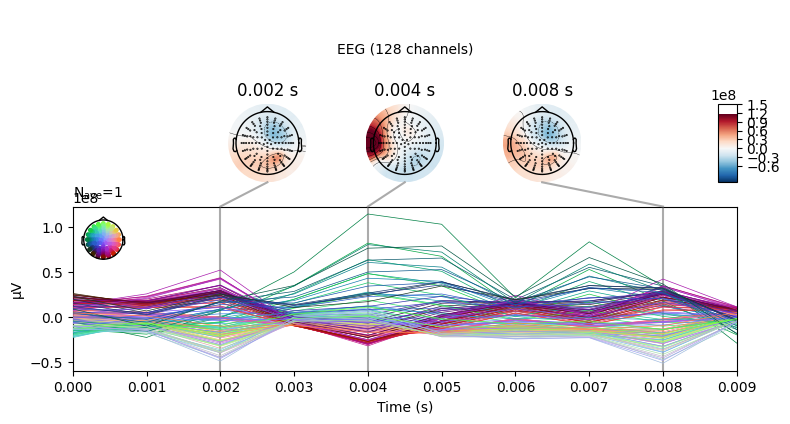

Using control points [0.         0.         0.46274129]


In [7]:
from invert import Solver
solver = Solver("SSMP")
solver.make_inverse_operator(fwd, evoked)
stc_ = solver.apply_inverse_operator(evoked)
stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info)
evoked_.plot_joint()

Using control points [0.27399019 0.3225509  0.67265394]


c:\Users\lukas\Dokumente\projects\invert\dev\..\invert\solvers\base.py:109: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
No projector specified for this dataset. Please consider the method self.add_proj.


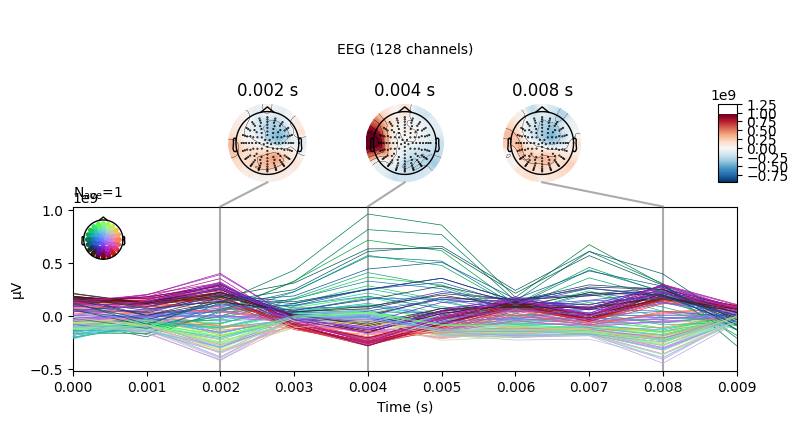

Using control points [0.         0.         0.19710002]
Using control points [0.         0.         0.07003984]
Using control points [0.         0.         0.33375516]
Using control points [0.         0.         0.25100621]
Using control points [0.24451155 0.2938597  0.611499  ]
Using control points [0.24451155 0.2938597  0.611499  ]


In [6]:
from invert import Solver

# solver_ = Solver("eLORETA")
# solver_.make_inverse_operator(fwd, evoked)
stc_ = solver_.apply_inverse_operator(evoked)
stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver_.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info)
evoked_.plot_joint()

# Big Loop

In [13]:
from invert import Solver
# from invert.config import all_solvers
from invert.evaluate import nmse, corr, eval_mean_localization_error, eval_auc
from invert.adapters import contextualize_bd
import pickle as pkl


all_solvers = [ "SOMP", "SSMP", "SubSMP", "MNE", "dSPM", "LORETA", "eLORETA", "Bayesian Beamformer LORETA"]
settings = dict(number_of_sources=(1, 4), extents=(1, 25), duration_of_trial=0.1, target_snr=1e99)

# errors_corr = {sname: [] for sname in all_solvers}
# errors_mle = {sname: [] for sname in all_solvers}
# errors_auc = {sname: [] for sname in all_solvers}

# solvers = dict()

for i in range(20):
    print(i)
    sim = Simulation(fwd, info, settings).simulate(2)
    stc = sim.source_data[0]
    evoked = sim.eeg_data[0].average()

    for solver_name in all_solvers:
        print(solver_name)
        solver = Solver(solver=solver_name)
        if (not solver_name in solvers):
            solvers[solver_name] = solver.make_inverse_operator(fwd, evoked, alpha="auto")
        stc_hat = solvers[solver_name].apply_inverse_operator(evoked)
        # stc_hat.plot(**pp, brain_kwargs=dict(title=solver.name))
        # error = np.mean(corr(stc.data, stc_hat.data))
        
        error_corr = np.mean(corr(stc.data, stc_hat.data))
        try:
            error_mle = eval_mean_localization_error(stc.data[:, 0], stc_hat.data[:, 0], pos)
        except:
            error_mle = np.nan
        error_auc = eval_auc(stc.data[:, 0], stc_hat.data[:, 0], pos)

        errors_corr[solver_name].append( error_corr )
        errors_mle[solver_name].append( error_mle )
        errors_auc[solver_name].append( error_auc )
        # print(error_corr, error_mle, error_auc)
    
    # print("Saving errors")
    # fn = "errors.pkl"
    # with open(fn, 'wb') as f:
    #     pkl.dump(errors, f)

0
-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 997.10it/s]


source data shape:  (1284, 100) (1284, 100)


100%|██████████| 2/2 [00:00<00:00, 46.08it/s]


SOMP
SSMP
SubSMP
MNE


c:\Users\lukas\Dokumente\projects\invert\dev\..\invert\solvers\base.py:109: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


dSPM
LORETA
eLORETA
Bayesian Beamformer LORETA
1
-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 1004.98it/s]


source data shape:  (1284, 100) (1284, 100)


100%|██████████| 2/2 [00:00<00:00, 46.50it/s]


SOMP
SSMP
SubSMP
MNE


c:\Users\lukas\Dokumente\projects\invert\dev\..\invert\solvers\base.py:109: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


dSPM
LORETA
eLORETA
Bayesian Beamformer LORETA
2
-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 1992.54it/s]


source data shape:  (1284, 100) (1284, 100)


100%|██████████| 2/2 [00:00<00:00, 55.53it/s]


SOMP
SSMP
SubSMP


In [ ]:
# import pickle as pkl
# fn = "errors.pkl"
# with open(fn, 'rb') as f:
#     errors = pkl.load(f)

# Plot

In [36]:
df = pd.DataFrame(errors_mle)

plt.figure()
sns.distplot(df["eLORETA"])
sns.distplot(df["SubSMP"])

<AxesSubplot:xlabel='SubSMP', ylabel='Density'>

In [12]:
import pandas as pd
import seaborn as sns
sns.set(font_scale=0.8)

# df = pd.DataFrame(errors_corr)
# df = pd.DataFrame(errors_mle)
df = pd.DataFrame(errors_auc)

sorted_index = df.median().sort_values().index
df = df[sorted_index]

plt.figure()
sns.boxplot(data=df)
plt.title("Correlation with ground truth")


df_mean_var = pd.concat([df.mean(), df.std()], axis=1)
df_mean_var = df_mean_var.rename(columns={0: "Median", 1: "Variance"})
df_mean_var["MedVar"] = df_mean_var["Median"] / df_mean_var["Variance"]
df_mean_var["Method"] = df_mean_var.index
display(df_mean_var)

plt.figure()
sns.scatterplot(x="Median", y="Variance", hue="Method", size="MedVar", data=df_mean_var)
plt.xlabel("Median")
plt.ylabel("Variance")


,Median,Variance,MedVar,Method
SOMP,0.701484,0.234358,2.993211,SOMP
LORETA,0.709892,0.224988,3.155248,LORETA
SubSMP,0.786124,0.208100,3.777629,SubSMP
SSMP,0.775657,0.220724,3.514144,SSMP
MNE,0.926738,0.055955,16.562288,MNE
dSPM,0.901495,0.104659,8.613660,dSPM
eLORETA,0.953452,0.048746,19.559389,eLORETA
Bayesian Beamformer LORETA,0.930101,0.101613,9.153382,Bayesian Beamformer LORETA


Text(0, 0.5, 'Variance')

In [ ]:
settings = dict(number_of_sources=3, extents=(25, 35), duration_of_trial=0.025, target_snr=99999)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)

In [ ]:
# from invert.solvers.empirical_bayes import SolverChampagne
# from invert.solvers.esinet import SolverFullyConnected
# solver_fc = SolverFullyConnected().make_inverse_operator(fwd, evoked)
# solver_ch = SolverChampagne().make_inverse_operator(fwd, evoked)
from invert.evaluate import nmse, corr

stc_hat = solver_ch.apply_inverse_operator(evoked)
stc_hat.plot(**pp)
# brain.add_text(0.1, 0.9, "Champagne", 'title',
#                font_size=14)
error_ch = np.mean(corr(abs(stc.data), abs(stc_hat.data)))

stc_hat = solver_fc.apply_inverse_operator(evoked)
stc_hat.plot(**pp)
# brain.add_text(0.1, 0.9, "Fully-Connected", 'title',
#                font_size=14)
error_fc = np.mean(corr(abs(stc.data), abs(stc_hat.data)))

print(f"Champ: {error_ch}\nFC: {error_fc}")